# Effect of corpus size on similarity scores

## Data preparation

In [227]:
from svd2vec import svd2vec, FilesIO, Utils
from gensim.models import Word2Vec

import os
import time
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
all_documents = FilesIO.load_corpus("text8")

In [3]:
def split_documents(n_corpuses=5):
    corpuses = [all_documents]
    last_one = all_documents
    for i in range(n_corpuses - 1):
        last_one = [doc for doc in Utils.split(last_one, 2)][0]
        corpuses.append(last_one)
    return corpuses

In [4]:
def display_stats_corpus(corpus):
    def format_space(n):
        return '{:,}'.format(n).replace(',', ' ')
    print("=-=-=-=-=-=-=-=-=-=-=-=-")
    print("Documents: ", format_space(len(corpus)))
    print("Tokens:    ", format_space(sum([len(d) for d in corpus])))
    print("Vocabulary:", format_space(len(set.union(*[set(d) for d in corpus]))))
    print("")
def display_stats_corpuses(corpuses):
    for c in corpuses:
        display_stats_corpus(c)

In [5]:
corpuses = split_documents(n_corpuses=8)

In [6]:
display_stats_corpuses(corpuses)

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  1 701
Tokens:     17 005 208
Vocabulary: 253 855

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  851
Tokens:     8 510 000
Vocabulary: 171 364

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  426
Tokens:     4 260 000
Vocabulary: 115 041

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  213
Tokens:     2 130 000
Vocabulary: 80 835

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  107
Tokens:     1 070 000
Vocabulary: 54 958

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  54
Tokens:     540 000
Vocabulary: 35 299

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  27
Tokens:     270 000
Vocabulary: 23 256

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  14
Tokens:     140 000
Vocabulary: 14 915



In [189]:
sizes = [sum([len(d) for d in corpus]) for corpus in corpuses]

In [190]:
sizes

[17005208, 8510000, 4260000, 2130000, 1070000, 540000, 270000, 140000]

In [224]:
[sum([len(d) for d in documents]) for documents in corpuses]

[17005208, 8510000, 4260000, 2130000, 1070000, 540000, 270000, 140000]

## Training embeddings

In [50]:
size = 300
window = 5
min_count = np.logspace(2, 0, num=len(corpuses), dtype=int)

In [52]:
def train_embeddings_generic(corpuses, name, method):
    models = []
    total  = len(corpuses)
    start = time.time()
    for i, documents in enumerate(corpuses):
        print("Building", name, "embeddings", i + 1, "out of", total, "... ", end="", flush=True)
        s = time.time()
        if name == "svd":
            model = method(documents, size=size, window=window, min_count=min_count[i], workers=16, sub_threshold=1e-3)
        else:
            model = method(documents, size=size, window=window, min_count=min_count[i], workers=16)            
        models.append(model)
        print(time.time() - s, "s")
    end = time.time()
    print("Total time:", end-start, "s")
    return models 

In [53]:
def train_embeddings_svd(corpuses):
    return train_embeddings_generic(corpuses, "svd", svd2vec)

def train_embeddings_w2v(corpuses):
    return train_embeddings_generic(corpuses, "w2v", Word2Vec)

In [54]:
svd_models = train_embeddings_svd(corpuses)

Building svd embeddings 1 out of 8 ... 869.1858861446381 s
Building svd embeddings 2 out of 8 ... 504.4942533969879 s
Building svd embeddings 3 out of 8 ... 269.9330949783325 s
Building svd embeddings 4 out of 8 ... 197.5440912246704 s
Building svd embeddings 5 out of 8 ... 124.00200963020325 s
Building svd embeddings 6 out of 8 ... 119.4055163860321 s
Building svd embeddings 7 out of 8 ... 259.366242647171 s
Building svd embeddings 8 out of 8 ... 110.06909918785095 s
Total time: 2454.029150247574 s


In [55]:
w2v_models = train_embeddings_w2v(corpuses)

Building w2v embeddings 1 out of 8 ... 59.29939317703247 s
Building w2v embeddings 2 out of 8 ... 29.354618072509766 s
Building w2v embeddings 3 out of 8 ... 14.444426774978638 s
Building w2v embeddings 4 out of 8 ... 7.305715799331665 s
Building w2v embeddings 5 out of 8 ... 4.203349351882935 s
Building w2v embeddings 6 out of 8 ... 2.8870322704315186 s
Building w2v embeddings 7 out of 8 ... 1.9725663661956787 s
Building w2v embeddings 8 out of 8 ... 1.3193976879119873 s
Total time: 120.80217790603638 s


## Evaluation

In [219]:
def models_get_score(models, file):
    scores = []
    for model in models:
        try:
            if hasattr(model, 'wv'):
                m = model.wv
            else:
                m = model
            score = m.evaluate_word_pairs(file)[0]
        except ValueError:
            score = 0
        if isinstance(score, tuple):
            score = score[0]
        scores.append(score)
    return scores

def scores_dataframe(all_models, all_models_names, file):
    df = pd.DataFrame()
    for i, models in enumerate(all_models):
        df[all_models_names[i]] = models_get_score(models, file)
    df["tokens"] = sizes
    df.set_index("tokens", inplace=True)
    return df

def scores_dataframes(all_models, all_models_names, files):
    return [scores_dataframe(all_models, all_models_names, file) for file in files]

def plot_dataframes(dfs, names):
    for i, df in enumerate(dfs):
        ax = df.plot(style='.-')
        ax.set_ylim(0,1)
        ax.set_title(names[i])
        ax.set_xlabel("learning corpus tokens")
        ax.set_ylabel("pearson similarity coefficient")
        ax.grid(color='gray', linestyle='-', linewidth=0.5)
        #ax.xticks(xValues

In [220]:
files = [
    FilesIO.path('similarities/wordsim353.txt'),
    FilesIO.path('similarities/men_dataset.txt'),
    FilesIO.path('similarities/mturk.txt'),
    FilesIO.path('similarities/simlex999.txt'),
    FilesIO.path('similarities/rarewords.txt')
]

In [221]:
scores = scores_dataframes([svd_models, w2v_models], ["svd", "w2v"], files)

In [222]:
scores[0]

,svd,w2v
tokens,,
17005208,0.559349,0.654514
8510000,0.541139,0.593418
4260000,0.530778,0.481906
2130000,0.519484,0.374424
1070000,0.479832,0.293753
540000,0.450161,0.197586
270000,0.280359,0.078272
140000,0.232544,0.019742


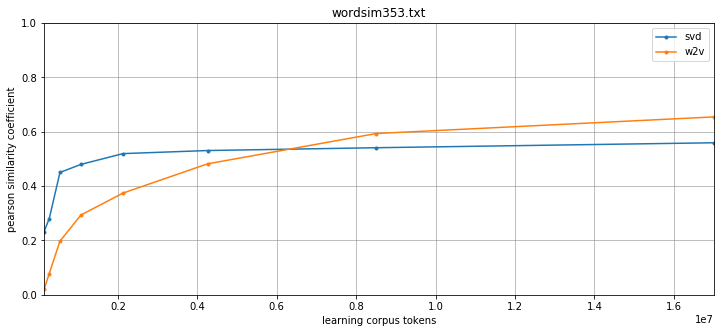

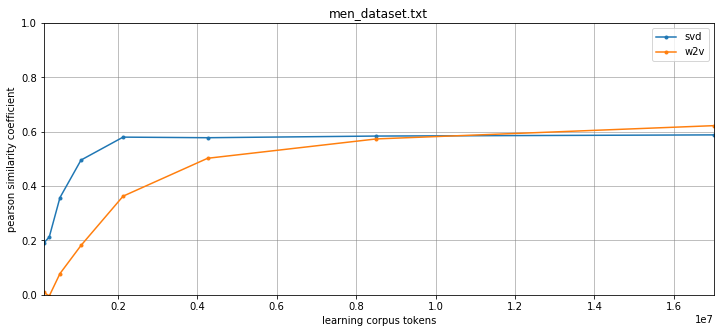

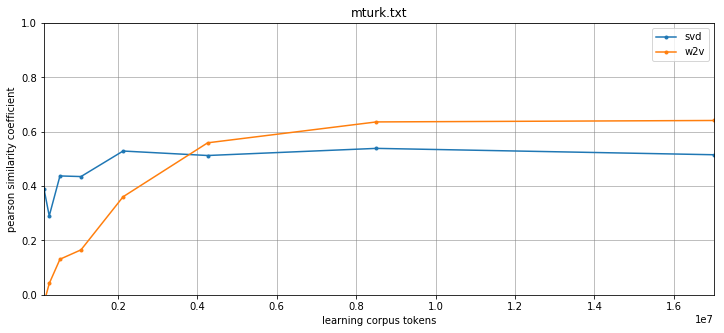

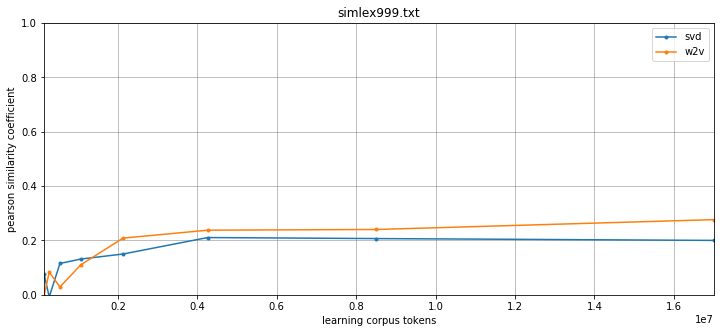

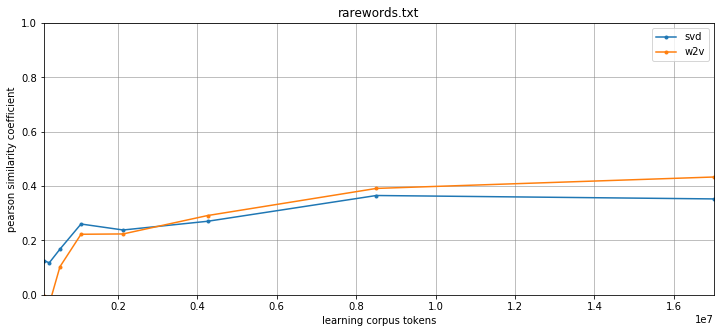

In [228]:
plot_dataframes(scores, [os.path.basename(f) for f in files])

In [166]:
[len(m.wv.vocab) for m in w2v_models]

[11815, 11688, 11518, 11784, 11418, 13722, 23256, 14915]

In [154]:
[len(m.vocabulary) for m in svd_models]

[11815, 11688, 11518, 11784, 11418, 13722, 23256, 14915]